In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wcpredictor

In this notebook, we look at different values of `epsilon` and `world_cup_weight`. We always have 20 years worth of training data and use FIFA organisation ratings.

## Computing the Loss

For the loss, we use 20 years of data and simulate the 2014 and 2018 world cups. The basic loss function just at the difference in stages that we predict for each team. We replicate this simulation 500 times and average the loss.

In [19]:
epsilon_trialed = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 2.0]
world_cup_weight_trialed = [1.0, 2.0, 5.0, 10.0, 15.0, 20.0]

```
wcpred_scan_hyperparameters --tournaments="2014,2018" --years_training="20" --ratings_choices="org" --epsilon_choices="0.0,0.01,0.05,0.1,0.15,0.2,0.25,0.5,1,2" --world_cup_weight_choices="1.0,2.0,5.0,10.0,15.0,20.0" --num_simulations=500 --num_thread=8
```

In [20]:
def get_loss_value(filename, agg = "mean"):
    losses = np.fromfile(filename, dtype=float, sep='\n')
    if agg == "mean":
        agg_loss = losses.mean()
    elif agg == "sum":
        agg_loss = losses.sum()
    return agg_loss

def get_all_losses(input_dir, year, epsilon_trialed, world_cup_weight_trialed, agg_method = "mean"):
    filenames = os.listdir(input_dir)
    filenames = [f for f in filenames if "_loss.txt" in f]
    vals = {"epsilon": [], "world_cup_weight": [], "loss": []}
    for ep in epsilon_trialed:
        for wc in world_cup_weight_trialed:
            vals["epsilon"].append(ep)
            vals["world_cup_weight"].append(wc)
            filename = f"{year}_20_org_all_comps_ep_{ep}_wc_{wc}_loss.txt"
            loss = get_loss_value(os.path.join(input_dir, filename), agg_method)
            vals["loss"].append(loss)
    df = pd.DataFrame(vals)
    return df

def get_win_proportion(filename, team):
    predicted_outcomes = pd.read_csv(filename)
    num_win = predicted_outcomes[predicted_outcomes["team"]==team]["W"]
    num_sim = predicted_outcomes["W"].sum()
    return (num_win / num_sim)[0]
    
def get_team_win_proportion(input_dir, team, year, epsilon_trialed, world_cup_weight_trialed):
    filenames = os.listdir(input_dir)
    filenames = [f for f in filenames if "_loss.txt" in f]
    vals = {"epsilon": [], "world_cup_weight": [], "win_prop": []}
    for ep in epsilon_trialed:
        for wc in world_cup_weight_trialed:
            vals["epsilon"].append(ep)
            vals["world_cup_weight"].append(wc)
            filename = f"{year}_20_org_all_comps_ep_{ep}_wc_{wc}.csv"
            win_prop = get_win_proportion(os.path.join(input_dir, filename), team)
            vals["win_prop"].append(win_prop)
    df = pd.DataFrame(vals)
    return df

### 2014 World Cup loss

#### Mean

<AxesSubplot: xlabel='world_cup_weight', ylabel='epsilon'>

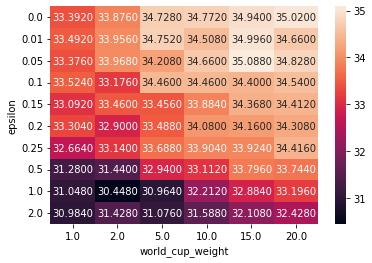

In [21]:
loss_data = get_all_losses("../output/", "2014", epsilon_trialed, world_cup_weight_trialed)
fp = loss_data.pivot_table(index='epsilon', columns='world_cup_weight', values='loss')
sns.heatmap(fp, annot=True, fmt=".4f")

### 2018 World Cup loss

<AxesSubplot: xlabel='world_cup_weight', ylabel='epsilon'>

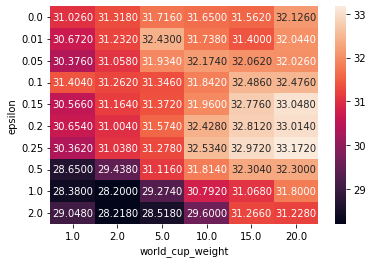

In [22]:
loss_data = get_all_losses("../output/", "2018", epsilon_trialed, world_cup_weight_trialed)
fp = loss_data.pivot_table(index='epsilon', columns='world_cup_weight', values='loss')
sns.heatmap(fp, annot=True, fmt=".4f")

These seem to suggest that `epsilon=1.0` and `world_cup_weight=2.0` would be the best:

```
wcpred_run_simulations --num_simulations=1000 --years_training_data=20 --output_csv="ep_1_wc_2.csv" --ratings_source="org" --epsilon=1 --world_cup_weight=2
```

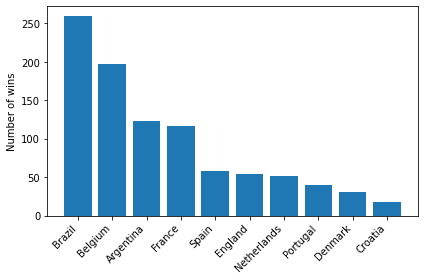

In [84]:
def plot_winner(input_csv):
    df = pd.read_csv(input_csv)
    df.sort_values(by="W", axis=0, ascending=False, inplace=True)
    # plot the top ten
    df = df[:10]
    fig, ax = plt.subplots(tight_layout=True)
    xvals = list(df.team.values)
    yvals = list(df.W.values)
    ax.bar(xvals, yvals)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")
    ax.set_ylabel("Number of wins")
    plt.show()

plot_winner("../ep_1_wc_2.csv")

In [85]:
def get_progression_probabilities(input_csv, n_sim):
    df = pd.read_csv(input_csv)
    df.sort_values(by="W", axis=0, ascending=False, inplace=True)
    vals = {"team": [], "R16": [], "QF": [], "SF": [], "F": [], "W": []}
    for team in df["team"]:
        vals["team"].append(team)
        vals["R16"].append(df[df["team"]==team].iloc[0][["R16", "QF", "SF", "RU", "W"]].sum()/n_sim)
        vals["QF"].append(df[df["team"]==team].iloc[0][["QF", "SF", "RU", "W"]].sum()/n_sim)
        vals["SF"].append(df[df["team"]==team].iloc[0][["SF", "RU", "W"]].sum()/n_sim)
        vals["F"].append(df[df["team"]==team].iloc[0][["RU", "W"]].sum()/n_sim)
        vals["W"].append(df[df["team"]==team].iloc[0][["W"]].sum()/n_sim)
    return pd.DataFrame(vals)

In [86]:
get_progression_probabilities("../ep_1_wc_2.csv", 1000)

,team,R16,QF,SF,F,W
0,Brazil,0.932,0.738,0.533,0.401,0.259
1,Belgium,0.928,0.691,0.494,0.316,0.197
2,Argentina,0.901,0.594,0.419,0.215,0.123
3,France,0.882,0.606,0.414,0.220,0.117
4,Spain,0.783,0.451,0.209,0.120,0.058
5,England,0.801,0.578,0.269,0.133,0.054
6,Netherlands,0.868,0.587,0.300,0.104,0.051
7,Portugal,0.826,0.403,0.186,0.095,0.040
8,Denmark,0.767,0.399,0.233,0.086,0.031
9,Croatia,0.669,0.319,0.126,0.054,0.017


## RPS score

In [87]:
def get_all_metrics(input_dir, method, epsilon_trialed, world_cup_weight_trialed, agg_method = "mean"):
    filenames = os.listdir(input_dir)
    filenames = [f for f in filenames if "_loss.txt" in f]
    vals = {"epsilon": [], "world_cup_weight": [], "loss": []}
    for ep in epsilon_trialed:
        for wc in world_cup_weight_trialed:
            vals["epsilon"].append(ep)
            vals["world_cup_weight"].append(wc)
            filename = f"{method}_20_org_all_comps_ep_{ep}_wc_{wc}.txt"
            loss = get_loss_value(os.path.join(input_dir, filename), agg_method)
            vals["loss"].append(loss)
    print
    df = pd.DataFrame(vals)
    return df

Here, we again use 20 years worth of training data and use the last 2 years as test data. We obtain the model outcome predictions for each game in the last two years and compute the Rank Probability Score for each game. We take either the average, or sum, RPS over the games to get a final metric.

In [88]:
epsilon_trialed = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 3.0]
world_cup_weight_trialed = [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]

```
wcpred_forecast_evaluation --metric="rps" --years_training=20 --years_testing=2 --ratings_choices="org" --epsilon_choices=0.0,0.1,0.2,0.3,0.4,0.5,1.0,2.0,3.0 --world_cup_weight_choices=1.0,2.0,3.0,4.0,5.0,10.0 --output_dir="rps_output" --num_thread=6
```

<AxesSubplot: xlabel='world_cup_weight', ylabel='epsilon'>

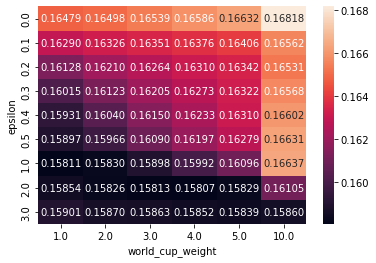

In [89]:
rps_data = get_all_metrics("../rps_output/", "rps", epsilon_trialed, world_cup_weight_trialed)
fp = rps_data.pivot_table(index='epsilon', columns='world_cup_weight', values='loss')
sns.heatmap(fp, annot=True, fmt=".5f")

This seems to suggest that around `epsilon=2.0` and `world_cup_weight=4.0` is the best - but note that many values actually give incredibly close average RPS scores. So it seems actually that any combination which includes a higher value of `epsilon` and/or `world_cup_weight` would be good.

```
wcpred_run_simulations --num_simulations=1000 --years_training_data=20 --output_csv="ep_2_wc_4.csv" --ratings_source="org" --epsilon=2 --world_cup_weight=4
```

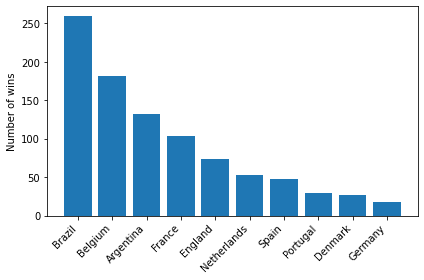

In [90]:
plot_winner("../ep_2_wc_4.csv")

In [91]:
get_progression_probabilities("../ep_2_wc_4.csv", 1000)

,team,R16,QF,SF,F,W
0,Brazil,0.923,0.736,0.526,0.369,0.259
1,Belgium,0.928,0.709,0.480,0.317,0.182
2,Argentina,0.904,0.614,0.452,0.232,0.132
3,France,0.884,0.591,0.403,0.201,0.104
4,England,0.787,0.557,0.315,0.147,0.073
5,Netherlands,0.859,0.559,0.256,0.109,0.053
6,Spain,0.760,0.418,0.199,0.114,0.047
7,Portugal,0.799,0.389,0.164,0.076,0.029
8,Denmark,0.737,0.376,0.208,0.097,0.027
9,Germany,0.630,0.288,0.134,0.057,0.017


## Brier score

Here, we again use 20 years worth of training data and use the last 2 years as test data. We obtain the model outcome predictions for each game in the last two years and compute the Brier Score for each game. We take either the average, or sum, RPS over the games to get a final metric.

```
wcpred_forecast_evaluation --metric="brier" --years_training=20 --years_testing=2 --ratings_choices="org" --epsilon_choices=0.0,0.1,0.2,0.3,0.4,0.5,1.0,2.0,3.0 --world_cup_weight_choices=1.0,2.0,3.0,4.0,5.0,10.0 --output_dir="brier_output" --num_thread=6
```

<AxesSubplot: xlabel='world_cup_weight', ylabel='epsilon'>

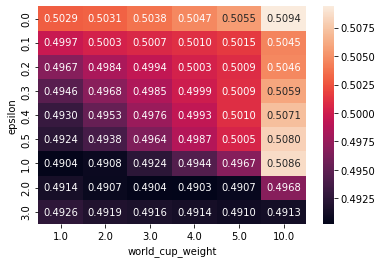

In [92]:
brier_data = get_all_metrics("../brier_output/", "brier", epsilon_trialed, world_cup_weight_trialed)
fp = brier_data.pivot_table(index='epsilon', columns='world_cup_weight', values='loss')
sns.heatmap(fp, annot=True, fmt=".4f")

Again seems to be best at `epsilon=2.0` and `world_cup_weight=4.0`, but very marginally better than the other choices...

## Testing out what other values might look like

```
wcpred_run_simulations --num_simulations=1000 --years_training_data=20 --output_csv="ep_0.2_wc_5.csv" --ratings_source="org" --epsilon=0.2 --world_cup_weight=5
```

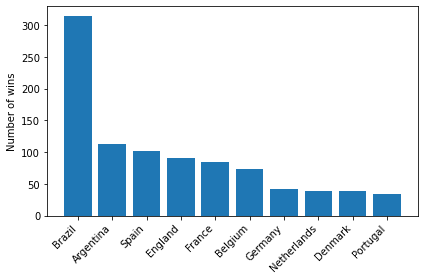

In [95]:
plot_winner("../ep_0.2_wc_5.csv")

In [96]:
get_progression_probabilities("../ep_0.2_wc_5.csv", 1000)

,team,R16,QF,SF,F,W
0,Brazil,0.951,0.783,0.599,0.447,0.314
1,Argentina,0.905,0.586,0.399,0.189,0.113
2,Spain,0.869,0.578,0.293,0.184,0.101
3,England,0.870,0.631,0.372,0.194,0.090
4,France,0.842,0.550,0.364,0.184,0.085
5,Belgium,0.841,0.502,0.271,0.160,0.073
6,Germany,0.760,0.432,0.196,0.098,0.042
7,Netherlands,0.855,0.533,0.265,0.092,0.039
8,Denmark,0.771,0.429,0.228,0.101,0.039
9,Portugal,0.802,0.367,0.179,0.082,0.034


```
wcpred_run_simulations --num_simulations=1000 --years_training_data=20 --output_csv="ep_0.5_wc_2.5.csv" --ratings_source="org" --epsilon=0.5 --world_cup_weight=2.5
```

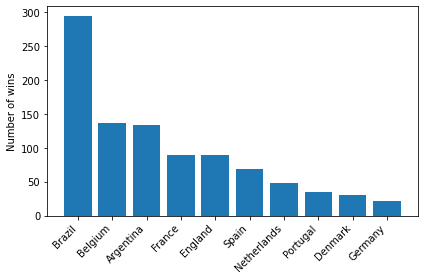

In [97]:
plot_winner("../ep_0.5_wc_2.5.csv")

In [98]:
get_progression_probabilities("../ep_0.5_wc_2.5.csv", 1000)

,team,R16,QF,SF,F,W
0,Brazil,0.946,0.784,0.587,0.429,0.294
1,Belgium,0.904,0.652,0.414,0.249,0.136
2,Argentina,0.918,0.615,0.437,0.235,0.133
3,France,0.858,0.573,0.366,0.190,0.090
4,England,0.807,0.592,0.341,0.188,0.089
5,Spain,0.811,0.513,0.253,0.139,0.068
6,Netherlands,0.860,0.537,0.263,0.104,0.048
7,Portugal,0.816,0.405,0.202,0.106,0.035
8,Denmark,0.764,0.447,0.238,0.091,0.031
9,Germany,0.662,0.302,0.123,0.046,0.021


```
wcpred_run_simulations --num_simulations=1000 --years_training_data=20 --output_csv="ep_1.0_wc_1.0.csv" --ratings_source="org" --epsilon=1.0 --world_cup_weight=1.0
```

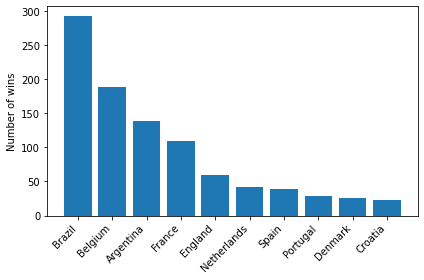

In [99]:
plot_winner("../ep_1.0_wc_1.0.csv")

In [100]:
get_progression_probabilities("../ep_1.0_wc_1.0.csv", 1000)

,team,R16,QF,SF,F,W
0,Brazil,0.931,0.772,0.565,0.414,0.292
1,Belgium,0.922,0.686,0.474,0.312,0.189
2,Argentina,0.903,0.610,0.402,0.227,0.139
3,France,0.906,0.621,0.422,0.225,0.109
4,England,0.814,0.603,0.322,0.154,0.060
5,Netherlands,0.853,0.545,0.281,0.101,0.042
6,Spain,0.781,0.440,0.199,0.098,0.039
7,Portugal,0.811,0.377,0.170,0.081,0.028
8,Denmark,0.744,0.373,0.213,0.081,0.025
9,Croatia,0.696,0.337,0.132,0.052,0.023


```
wcpred_run_simulations --num_simulations=1000 --years_training_data=20 --output_csv="ep_2.0_wc_3.0.csv" --ratings_source="org" --epsilon=2.0 --world_cup_weight=3.0
```

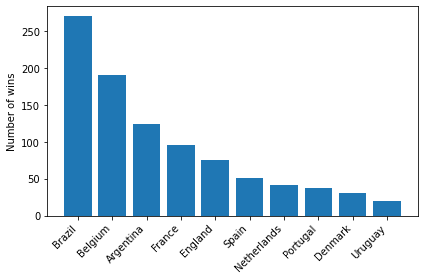

In [101]:
plot_winner("../ep_2.0_wc_3.0.csv")

In [102]:
get_progression_probabilities("../ep_2.0_wc_3.0.csv", 1000)

,team,R16,QF,SF,F,W
0,Brazil,0.934,0.761,0.550,0.395,0.270
1,Belgium,0.935,0.700,0.482,0.327,0.191
2,Argentina,0.919,0.633,0.441,0.227,0.124
3,France,0.883,0.584,0.390,0.191,0.095
4,England,0.815,0.596,0.337,0.159,0.075
5,Spain,0.737,0.425,0.200,0.106,0.051
6,Netherlands,0.851,0.530,0.244,0.107,0.042
7,Portugal,0.782,0.387,0.185,0.087,0.037
8,Denmark,0.731,0.378,0.215,0.075,0.031
9,Uruguay,0.739,0.306,0.124,0.056,0.020


```
wcpred_run_simulations --num_simulations=1000 --years_training_data=20 --output_csv="ep_2.0_wc_5.0.csv" --ratings_source="org" --epsilon=2.0 --world_cup_weight=5.0
```

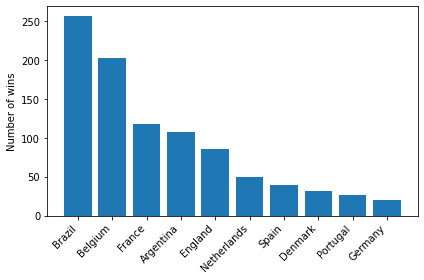

In [103]:
plot_winner("../ep_2.0_wc_5.0.csv")

In [104]:
get_progression_probabilities("../ep_2.0_wc_5.0.csv", 1000)

,team,R16,QF,SF,F,W
0,Brazil,0.944,0.742,0.552,0.391,0.256
1,Belgium,0.919,0.676,0.464,0.317,0.203
2,France,0.863,0.586,0.402,0.217,0.117
3,Argentina,0.910,0.636,0.443,0.215,0.107
4,England,0.816,0.582,0.321,0.171,0.085
5,Netherlands,0.867,0.573,0.265,0.127,0.050
6,Spain,0.759,0.412,0.183,0.097,0.039
7,Denmark,0.765,0.387,0.215,0.088,0.032
8,Portugal,0.822,0.377,0.174,0.080,0.027
9,Germany,0.643,0.306,0.117,0.054,0.020
